* [#4](https://github.com/salgo60/SCB-Wikidata/issues/4)
* denna [SCB4_linkroot.ipynb](https://github.com/salgo60/SCB-Wikidata/blob/main/notebook/SCB4_linkroot.ipynb)

In [1]:
import time

from datetime import datetime

now = datetime.now()
timestamp = now.timestamp()

start_time = time.time()
print("Start:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Start: 2025-11-16 02:52:25


In [2]:
from datetime import datetime

def log(level, msg):
    ts = datetime.now().strftime("%H:%M:%S")
    print(f"[{ts}] [{level}] {msg}")


In [3]:
def read_language_codes(file_path): 
    print(f"[DEBUG] Reading language codes from: {file_path}") 
    df = pd.read_csv(file_path) 
    lang_codes = df['Language Code'].dropna().unique().tolist() 
    print(f"[DEBUG] Found {len(lang_codes)} language codes.") 
    return lang_codes 
    
def read_domains(file_path): 
    print(f"[DEBUG] Reading domains from: {file_path}") 
    df = pd.read_csv(file_path, header=None, names=['domain']) 
    domains_list = df['domain'].dropna().unique().tolist() 
    print(f"[DEBUG] Found {len(domains_list)} domains.") 
    return domains_list

In [10]:
import pandas as pd
from urllib.parse import urlparse

# -------------------------------------------------
# LADDA LÄNKAR
# -------------------------------------------------
df = pd.read_csv(CHECKPOINT_LINKS)

print("Alla rader i checkpoint:", len(df))

# Ta unika URL:er
urls = df["url"].dropna().unique().tolist()
total = len(urls)
print(f"Totalt unika URL: {total}")

# -------------------------------------------------
# LÄNKAR PER WIKIPEDIA-SPRÅK
# -------------------------------------------------

# Försök hitta vilken kolumn som innehåller språkkoden
possible_lang_cols = ["lang", "language", "wiki", "wiki_lang", "language_code"]
lang_col = None

for c in possible_lang_cols:
    if c in df.columns:
        lang_col = c
        break

if lang_col is None:
    print("⚠️ Hittar ingen språk-kolumn i datan! Inga språk-stats kan visas.")
else:
    print(f"\nSpråk-kolumn hittad: '{lang_col}'")

    # Totalt antal länkar per språk (inkl. dubbletter)
    print("\n--- Statistik per språk (alla rader) ---")
    lang_counts_all = df[lang_col].value_counts()
    for lang, cnt in lang_counts_all.items():
        print(f"{lang:5} {cnt}")

    # Antal UNIKA URLer per språk
    print("\n--- Statistik per språk (unika URL:er) ---")
    df_unique = df.drop_duplicates(subset=["url"])
    lang_counts_unique = df_unique[lang_col].value_counts()
    for lang, cnt in lang_counts_unique.items():
        print(f"{lang:5} {cnt}")

    print("\nAntal språk:", len(lang_counts_all))

# -------------------------------------------------
# DOMÄNSTATISTIK
# -------------------------------------------------
domains = [urlparse(u).netloc.lower() for u in urls]
domain_counts = pd.Series(domains).value_counts()

print("\n--- Statistik per domän (flest först) ---")
for dom, cnt in domain_counts.items():
    print(f"{dom:35} {cnt}")

print("\nAntal domäner:", len(domain_counts))

# -------------------------------------------------
# LADDA PREVIOUS STATUS (resume)
# -------------------------------------------------
status_map = {}
if os.path.exists(CHECKPOINT_STATUS):
    prev = pd.read_csv(CHECKPOINT_STATUS)
    status_map = dict(zip(prev["url"], prev["status"]))
    print("\nLaddade tidigare status:", len(status_map))

# Filtrera bort redan testade länkar
remaining = [u for u in urls if u not in status_map]

print("\n--- Sammanfattning ---")
print(f"Totalt unika URL:         {total}")
print(f"Redan testade:             {len(status_map)}")
print(f"Kvar att testa:            {len(remaining)}")
print(f"Antal domäner:             {len(domain_counts)}")

# Visa topp 10 domäner
print("\nTopp 10 domäner:")
print(domain_counts.head(10))



Alla rader i checkpoint: 110927
Totalt unika URL: 23871

Språk-kolumn hittad: 'lang'

--- Statistik per språk (alla rader) ---
sv    71851
fi    9316
no    6638
en    6408
pl    2668
de    2224
it    2122
ro    1905
da    1818
es    1453
hu    1193
pt    513
ru    500
tr    395
nn    362
nl    352
is    315
vi    226
hr    174
cs    140
ca    96
se    79
sl    56
et    41
lv    28
eo    19
sk    18
so    6
rm    4
cy    3
ga    2
ceb   2

--- Statistik per språk (unika URL:er) ---
sv    20931
da    1304
en    815
fi    341
de    103
es    75
ru    56
pt    44
no    36
pl    25
it    21
nl    17
hu    16
cs    13
ro    12
ca    11
tr    10
hr    7
nn    6
et    6
is    6
vi    5
lv    2
eo    2
rm    2
sk    2
ga    1
sl    1
so    1

Antal språk: 32

--- Statistik per domän (flest först) ---
geodata.scb.se                      18369
www.scb.se                          2931
kommunsiffror.scb.se                1444
www.statistikdatabasen.scb.se       472
share.scb.se                     

In [9]:
# -----------------------------------------------------------
# Fetch exturlusage entries for one lang/domain
# -----------------------------------------------------------
def fetch_exturlusage(lang, domain):
    base = f"https://{lang}.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "list": "exturlusage",
        "euquery": domain,
        "eulimit": "max"
    }
    while True:
        r = session.get(base, params=params, timeout=10)
        data = r.json()
        for item in data.get("query", {}).get("exturlusage", []):
            yield {
                "lang": lang,
                "page_title": item.get("title"),
                "url": item.get("url"),
                "wiki_link": f"https://{lang}.wikipedia.org/wiki/{item.get('title').replace(' ', '_')}"
            }

        if "continue" not in data:
            break
        params.update(data["continue"])
        time.sleep(0.3)
# -----------------------------------------------------------
# Modified main() with resume support
# -----------------------------------------------------------


In [5]:
# Klistra in i en Notebook-cell och kör.
# Kräver: requests, tqdm, pandas
# !pip install requests tqdm pandas

import time
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed
from urllib.parse import urlparse
import requests
import pandas as pd
import os
from tqdm.notebook import tqdm

# -------------------------
# CONFIG — justera vid behov
# -------------------------
CONFIG = {
    "wiki_versions_file": "sources/wiki_versions.csv",
    "domains_file": "sources/domains.csv",
    "checkpoint_links": "results/_checkpoint_exturlusage.csv",
    "checkpoint_status": "results/_checkpoint_status.csv",
    "out_all_links": "results/all_links.csv",
    "out_dead_links": "results/dead_links.csv",
    "max_workers_cap": 1,        # hårt tak
    "initial_concurrency": 80,    # startvärde för adaptiv concurrency
    "min_concurrency": 5,
    "monitor_interval": 5.0,      # sek mellan monitor-justeringar
    "rolling_window": 200,        # hur många senaste requests som används för latency/err rate
    "target_avg_latency": 1.0,    # mål (s) - om avg>target -> minska concurrency
    "increase_step": 5,           # öka concurrency med detta om allt är bra
    "decrease_step": 10,          # minska concurrency med detta om långsamt
    "per_domain_backoff_base": 10, # sekunder baseline för exponential backoff
    "per_domain_fail_threshold": 3,# antal på varandra följande fel innan backoff eskalerar
    "status_save_every": 500,     # spara checkpoints varje N färdiga requests
    "request_timeout": 0.0,       # timeout för requests
    "use_get_stream": True,       # om True: använd GET stream=True istället för HEAD
    "max_retries": 1,             # simpla retries per request (on transient errors)
}

os.makedirs("results", exist_ok=True)

# -------------------------
# Session & helpers
# -------------------------
session = requests.Session()
session.headers.update({"User-Agent": "SCB-LinkAudit/1.0 (https://www.scb.se/)"})

SCB_SOFT_404_SIGNALS = [
    "sidan kunde inte hittas",
    "vi vill gärna hjälpa dig vidare",
    "snabba fakta om sverige",
    "ta dig vidare till"
]

def detect_scb_soft_404(url):
    try:
        r = session.get(url, timeout=6)
    except Exception:
        return "ERROR"
    if r.status_code == 404:
        return "HARD_404"
    html = r.text.lower()
    if any(sig in html for sig in SCB_SOFT_404_SIGNALS):
        return "SOFT_404"
    if r.status_code >= 400:
        return r.status_code
    return 200

def do_request(url, timeout, use_get_stream):
    """
    Enkelt request-wrapper: return (status, latency_seconds)
    """
    start = time.time()
    try:
        if use_get_stream:
            r = session.get(url, allow_redirects=True, timeout=timeout, stream=True)
        else:
            r = session.head(url, allow_redirects=True, timeout=timeout)
        status = r.status_code
    except Exception as e:
        # kan skilja mellan timeout, connection error, etc.
        status = "ERROR"
    latency = time.time() - start
    return status, latency

# -------------------------
# Adaptive concurrency primitives
# -------------------------
monitor_state = {
    "concurrency_limit": CONFIG["initial_concurrency"],
    "active_count": 0,
    "recent_latencies": [],   # list of float
    "recent_results": [],     # list of (url, status)
    "lock": threading.Lock(),
    "cond": threading.Condition(threading.Lock()),
    "stopped": False,
    "completed_count": 0,
}

# Domain-level stats/backoff
domain_stats = {}  # domain -> dict {failures, last_fail_time, backoff_until, total, ok, slow_count}

def domain_info(domain):
    if domain not in domain_stats:
        domain_stats[domain] = {"failures":0, "last_fail":0, "backoff_until":0, "total":0, "ok":0, "slow_count":0}
    return domain_stats[domain]

# -------------------------
# Load or build link list (checkpointing)
# -------------------------
def load_or_fetch_links():
    # If checkpoint exists, load it; else, collect via your fetch_exturlusage loop
    if os.path.exists(CONFIG["checkpoint_links"]):
        df_links = pd.read_csv(CONFIG["checkpoint_links"])
        print(f"[Checkpoint] Loaded {len(df_links)} links from {CONFIG['checkpoint_links']}")
    else:
        # --- Minimal implementation to build rows using the user's fetch_exturlusage ---
        # You should replace this block with your own fetch_exturlusage(lang, domain) implementation
        # For now we will read sources from files and create placeholder; you must provide fetch_exturlusage
        langs = pd.read_csv(CONFIG["wiki_versions_file"])["Language Code"].dropna().tolist()
        domains = pd.read_csv(CONFIG["domains_file"], header=None)[0].dropna().tolist()
        rows = []
        print("Fetching exturlusage… (please ensure fetch_exturlusage is available in your namespace)")
        for lang in langs:
            for domain in domains:
                for item in fetch_exturlusage(lang, domain):
                    rows.append(item)
            # save incremental for safety
            pd.DataFrame(rows).to_csv(CONFIG["checkpoint_links"], index=False)
        df_links = pd.DataFrame(rows)
        print(f"Saved checkpoint: {CONFIG['checkpoint_links']}")
    return df_links

# -------------------------
# Save status checkpoint
# -------------------------
def save_status_checkpoint(status_map):
    df = pd.DataFrame([{"url":u, "status":s} for u,s in status_map.items()])
    df.to_csv(CONFIG["checkpoint_status"], index=False)

# -------------------------
# Worker logic
# -------------------------
def worker_task(url, tested_status):
    """
    The worker will:
     - check domain backoff
     - wait for "permission" according to global concurrency_limit
     - perform request(s)
     - update monitor_state (latency + result)
     - return (url, status)
    """
    parsed = urlparse(url)
    domain = parsed.netloc.lower()

    # If domain is in backoff, skip
    dinfo = domain_info(domain)
    now = time.time()
    if dinfo.get("backoff_until",0) > now:
        return url, "SKIPPED_BACKOFF"

    # Wait for global concurrency permission
    cond = monitor_state["cond"]
    with cond:
        while monitor_state["active_count"] >= monitor_state["concurrency_limit"]:
            cond.wait(timeout=0.5)
        monitor_state["active_count"] += 1

    # perform request
    status = None
    latency = None
    try:
        # small per-domain polite sleep if too many recent calls for same domain
        # (very simple, not a full rate-limiter)
        time.sleep(0.0)

        attempts = 0
        while attempts <= CONFIG["max_retries"]:
            attempts += 1
            status, latency = do_request(url, CONFIG["request_timeout"], CONFIG["use_get_stream"])
            # Special SCB detection if scb in url and we got 200 -> run detect
            if "scb.se" in url.lower() and status == 200:
                status = detect_scb_soft_404(url)
            # Accept non-200 numeric codes as final; for "ERROR" we may retry once
            if status != "ERROR":
                break
        # update domain stats
        dinfo = domain_info(domain)
        dinfo["total"] += 1
        if status == 200:
            dinfo["ok"] += 1
            dinfo["failures"] = 0
        elif status == "SKIPPED_BACKOFF":
            pass
        else:
            dinfo["failures"] += 1
            dinfo["last_fail"] = time.time()
            # set backoff if threshold exceeded
            if dinfo["failures"] >= CONFIG["per_domain_fail_threshold"]:
                backoff_seconds = CONFIG["per_domain_backoff_base"] * (2 ** (dinfo["failures"] - CONFIG["per_domain_fail_threshold"]))
                backoff_seconds = min(backoff_seconds, 3600)  # cap to 1h
                dinfo["backoff_until"] = time.time() + backoff_seconds

    finally:
        # update monitor_state
        with monitor_state["lock"]:
            monitor_state["recent_results"].append((url, status, latency))
            if latency is not None:
                monitor_state["recent_latencies"].append(latency)
            # keep rolling window
            if len(monitor_state["recent_latencies"]) > CONFIG["rolling_window"]:
                monitor_state["recent_latencies"] = monitor_state["recent_latencies"][-CONFIG["rolling_window"]:]
            if len(monitor_state["recent_results"]) > CONFIG["rolling_window"]:
                monitor_state["recent_results"] = monitor_state["recent_results"][-CONFIG["rolling_window"]:]
            monitor_state["completed_count"] += 1

        # release active slot
        cond = monitor_state["cond"]
        with cond:
            monitor_state["active_count"] -= 1
            cond.notify_all()

    return url, status

# -------------------------
# Monitor thread — adapts concurrency + prints stats
# -------------------------
def monitor_thread_fn(total_to_check, tested_map):
    last_print = 0
    while not monitor_state["stopped"]:
        time.sleep(CONFIG["monitor_interval"])
        with monitor_state["lock"]:
            latencies = monitor_state["recent_latencies"][:]
            results = monitor_state["recent_results"][:]
            completed = monitor_state["completed_count"]
            active = monitor_state["active_count"]
            curr_limit = monitor_state["concurrency_limit"]

        # compute metrics
        avg_latency = (sum(latencies)/len(latencies)) if latencies else 0.0
        err_count = sum(1 for (_,s,_) in results if s not in (200, "SKIPPED_BACKOFF", None))
        recent = len(results)
        err_rate = (err_count / recent) if recent else 0.0
        pct_done = (completed / total_to_check * 100) if total_to_check else 0.0

        # adapt concurrency
        changed = False
        if avg_latency > CONFIG["target_avg_latency"] and curr_limit > CONFIG["min_concurrency"]:
            # decrease
            new_limit = max(CONFIG["min_concurrency"], curr_limit - CONFIG["decrease_step"])
            monitor_state["concurrency_limit"] = new_limit
            changed = True
        elif avg_latency <= CONFIG["target_avg_latency"] and curr_limit < CONFIG["max_workers_cap"]:
            # increase gently
            new_limit = min(CONFIG["max_workers_cap"], curr_limit + CONFIG["increase_step"])
            monitor_state["concurrency_limit"] = new_limit
            changed = True

        # Print concise status line
        slow_domains = sorted(domain_stats.items(), key=lambda kv: kv[1].get("failures",0), reverse=True)[:5]
        slow_summary = ", ".join([f"{d}:{s['failures']}" for d,s in slow_domains if s['failures']>0]) or "none"
        print(f"[Monitor] done={completed}/{total_to_check} ({pct_done:.1f}%) active={active} limit={monitor_state['concurrency_limit']} avg_lat={avg_latency:.2f}s err_rate={err_rate:.2%} slow_domains={slow_summary}")
        if changed:
            # wake waiting tasks so they re-check concurrency_limit
            with monitor_state["cond"]:
                monitor_state["cond"].notify_all()

        # save status checkpoint occasionally
        if completed % CONFIG["status_save_every"] == 0 and completed > 0:
            # build simple tested_map from recent_results + existing
            with monitor_state["lock"]:
                for (u,s,_) in monitor_state["recent_results"]:
                    tested_map[u] = s
            save_status_checkpoint(tested_map)

# -------------------------
# High-level runner
# -------------------------
def run_audit():
    # 1) load links (or fetch)
    df_links = load_or_fetch_links()
    print(f"Total links (raw): {len(df_links)}")
    # dedupe
    unique_urls = pd.Series(df_links["url"].dropna().unique(), name="url")
    print(f"Unique URLs to test: {len(unique_urls)}")

    # 2) load tested status checkpoint
    tested_map = {}
    if os.path.exists(CONFIG["checkpoint_status"]):
        s = pd.read_csv(CONFIG["checkpoint_status"])
        tested_map = dict(zip(s["url"], s["status"]))
        print(f"[Checkpoint] Loaded {len(tested_map)} tested statuses")

    # build list of urls to test (unique minus already tested)
    remaining = [u for u in unique_urls.tolist() if u not in tested_map]
    total_to_check = len(remaining)
    print(f"URLs to test (unique): {total_to_check}")

    # start monitor thread
    monitor_t = threading.Thread(target=monitor_thread_fn, args=(total_to_check, tested_map), daemon=True)
    monitor_t.start()

    # threadpool for workers
    max_workers = CONFIG["max_workers_cap"]
    futures = {}
    pbar = tqdm(total=total_to_check, desc="Checking URLs")

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        # submit all tasks but they internally obey concurrency_limit via condition
        for url in remaining:
            futures[ex.submit(worker_task, url, tested_map)] = url

        # iterate as they complete to update pbar and tested_map
        try:
            for fut in as_completed(futures):
                url = futures[fut]
                try:
                    u, status = fut.result()
                except Exception as e:
                    u, status = url, "ERROR"
                tested_map[u] = status
                pbar.update(1)

                # periodic checkpoint
                if monitor_state["completed_count"] % CONFIG["status_save_every"] == 0:
                    save_status_checkpoint(tested_map)

        except KeyboardInterrupt:
            print("User aborted. Saving checkpoint...")
            monitor_state["stopped"] = True
            save_status_checkpoint(tested_map)
            raise
        finally:
            monitor_state["stopped"] = True
            pbar.close()

    # merge back to full dataframe
    df_links["status"] = df_links["url"].map(tested_map)
    df_links.to_csv(CONFIG["out_all_links"], index=False)
    dead_df = df_links[df_links["status"].isin(["HARD_404", "SOFT_404", "ERROR"])]
    dead_df.to_csv(CONFIG["out_dead_links"], index=False)
    save_status_checkpoint(tested_map)
    print("Finished. Results saved to:", CONFIG["out_all_links"], CONFIG["out_dead_links"])

# -------------------------
# Run!
# -------------------------
# NOTE: This cell will run in the notebook and print monitor lines periodically.
# If you want non-blocking background execution, run it via subprocess from another cell.
run_audit()


Totalt unika URL: 23871
Laddade tidigare status: 1603
Återstår att testa: 22268


Kollar SCB-länkar:   0%|          | 0/22268 [00:00<?, ?it/s]

[COOLDOWN] lat=0.1s err=100.00% => väntar 60s
[COOLDOWN] lat=0.1s err=100.00% => väntar 120s
[COOLDOWN] lat=0.1s err=50.00% => väntar 120s
[COOLDOWN] lat=0.1s err=100.00% => väntar 240s
[COOLDOWN] lat=1.4s err=42.86% => väntar 60s
[COOLDOWN] lat=0.0s err=100.00% => väntar 120s
[COOLDOWN] lat=0.0s err=100.00% => väntar 240s
[COOLDOWN] lat=0.1s err=100.00% => väntar 480s
[COOLDOWN] lat=0.2s err=100.00% => väntar 960s
[COOLDOWN] lat=0.1s err=100.00% => väntar 1800s
[COOLDOWN] lat=0.8s err=100.00% => väntar 1800s
[COOLDOWN] lat=0.2s err=45.45% => väntar 60s
[COOLDOWN] lat=0.0s err=100.00% => väntar 120s
[COOLDOWN] lat=0.0s err=100.00% => väntar 240s
[COOLDOWN] lat=0.0s err=100.00% => väntar 480s
[COOLDOWN] lat=0.1s err=100.00% => väntar 960s
[COOLDOWN] lat=0.1s err=100.00% => väntar 1800s
[COOLDOWN] lat=0.1s err=100.00% => väntar 1800s
[COOLDOWN] lat=0.1s err=100.00% => väntar 1800s
[COOLDOWN] lat=0.3s err=50.00% => väntar 1800s
[COOLDOWN] lat=0.1s err=100.00% => väntar 1800s


KeyboardInterrupt: 

Preview (truncated to first 40 domains):


domain,lang,api.scb.se,geodata.scb.se,kommunsiffror.scb.se,myndighetsregistret.scb.se,regina.scb.se,scb.se,share.scb.se,sni2007.scb.se,ssd.scb.se,...,www.pc-axis.scb.se,www.pubkat.scb.se,www.pxweb.scb.se,www.rennaringsstatistik.scb.se,www.scb.se,www.scb.se:80,www.sni2007.scb.se,www.ssd.scb.se,www.statistikdatabasen.scb.se,www.sverigeisiffror.scb.se
0,sv,1,18729,661,4,35,48,1155,1,1,...,0,3,1,1,43907,0,1,231,6848,98
1,fi,0,212,1,0,2,10,15,0,1,...,0,0,0,0,7870,0,0,86,1111,1
2,no,0,0,0,0,0,16,0,0,0,...,0,0,0,0,6412,0,0,46,139,0
3,en,1,3,4,0,0,23,1309,0,0,...,2,0,0,0,4632,1,0,23,392,7
4,pl,0,0,0,0,0,9,0,0,0,...,0,2,0,0,2498,5,0,0,98,53
5,de,0,0,0,0,0,3,8,0,0,...,0,3,0,0,1350,0,0,7,849,0
6,it,0,0,1,0,0,7,0,0,0,...,0,0,0,0,2101,0,0,6,6,1
7,ro,0,0,0,0,0,1,0,0,0,...,0,0,0,0,686,0,0,2,1212,0
8,da,0,0,1148,0,0,13,10,0,0,...,0,0,0,0,578,0,0,4,60,0
9,es,0,0,0,0,0,2,11,0,0,...,0,0,0,0,647,0,0,5,788,0


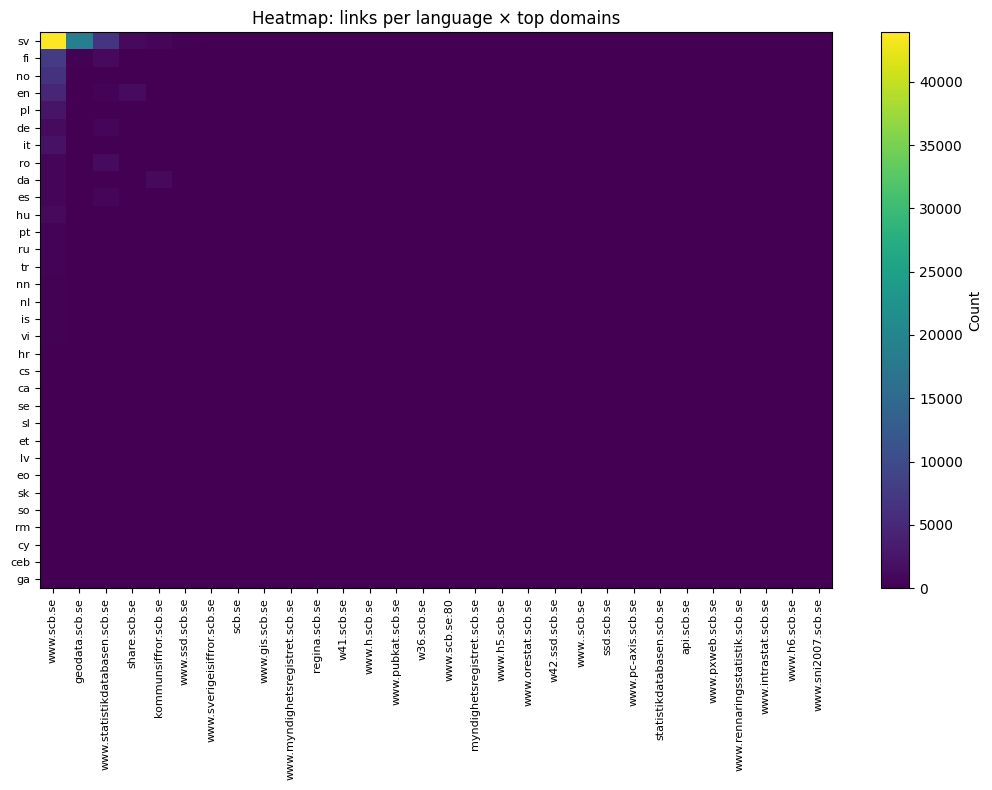

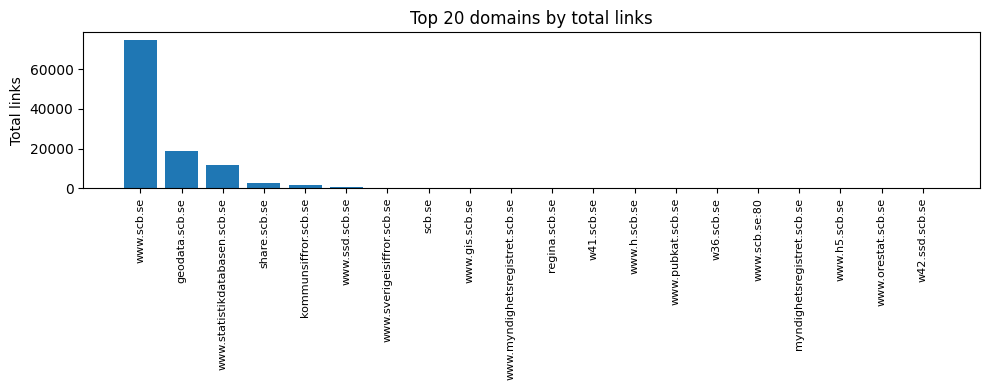


Saved files:
- Full pivot CSV: results/heatmap_counts.csv
- Full pivot HTML: results/heatmap_counts.html
- Long-form summary CSV: results/domain_lang_summary.csv


In [12]:
# Heatmap + CSV/HTML export + bar chart (Notebook)
import os
import pandas as pd
from urllib.parse import urlparse
import numpy as np
import matplotlib.pyplot as plt

# Helper for interactive display (optional)
try:
    from ace_tools import display_dataframe_to_user
    have_display = True
except Exception:
    have_display = False

# Paths - ändra om din fil ligger annorlunda
CHECKPOINT_LINKS = "results/_checkpoint_exturlusage.csv"
OUT_CSV = "results/heatmap_counts.csv"
OUT_HTML = "results/heatmap_counts.html"
OUT_LOG = "results/domain_lang_summary.csv"

# Kontrollera fil
if not os.path.exists(CHECKPOINT_LINKS):
    raise FileNotFoundError(f"Input file not found: {CHECKPOINT_LINKS}. Flytta filen eller uppdatera CHECKPOINT_LINKS.")

# Läs in
df = pd.read_csv(CHECKPOINT_LINKS)

# Försök hitta språk-kolumn
possible_lang_cols = ["lang", "language", "wiki", "wiki_lang", "language_code"]
lang_col = next((c for c in possible_lang_cols if c in df.columns), None)
if lang_col is None:
    for c in df.columns:
        if c.lower() in possible_lang_cols:
            lang_col = c
            break
if lang_col is None:
    raise ValueError("Hittar ingen språk-kolumn i CSV. Förväntade någon av: " + ", ".join(possible_lang_cols))

# Extrahera domän
def extract_domain(u):
    try:
        return urlparse(u).netloc.lower()
    except Exception:
        return ""
df['domain'] = df['url'].fillna('').apply(extract_domain)
df[lang_col] = df[lang_col].astype(str).str.strip()

# Pivot: språk x domän
pivot = df.pivot_table(index=lang_col, columns='domain', values='url', aggfunc='count', fill_value=0)
lang_totals = pivot.sum(axis=1).sort_values(ascending=False)
pivot = pivot.reindex(lang_totals.index)

# Totals per domain
domain_totals = pivot.sum(axis=0).sort_values(ascending=False)

# Save outputs
pivot.to_csv(OUT_CSV)
pivot.to_html(OUT_HTML)
summary = pivot.reset_index().melt(id_vars=[lang_col], var_name='domain', value_name='count')
summary = summary.sort_values(['count'], ascending=False)
summary.to_csv(OUT_LOG, index=False)

# Present a preview
preview = pivot.copy()
if preview.shape[1] > 40:
    preview = preview.iloc[:, :40]
if have_display:
    display_dataframe_to_user("Language x Domain counts (preview)", preview.reset_index())
else:
    print("Preview (truncated to first 40 domains):")
    display(preview.reset_index().head(40))

# --- Heatmap (top domains) ---
TOP_DOMAINS = 30
top_domains = domain_totals.head(TOP_DOMAINS).index.tolist()
plot_pivot = pivot[top_domains]

plt.figure(figsize=(max(8, len(top_domains)*0.35), max(6, len(plot_pivot.index)*0.25)))
plt.imshow(plot_pivot.values, aspect='auto', interpolation='nearest')
plt.colorbar(label='Count')
plt.xticks(ticks=np.arange(len(top_domains)), labels=top_domains, rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(len(plot_pivot.index)), labels=plot_pivot.index, fontsize=8)
plt.title('Heatmap: links per language × top domains')
plt.tight_layout()
plt.show()

# --- Bar chart of top domains overall ---
top20 = domain_totals.head(20)
plt.figure(figsize=(10,4))
plt.bar(range(len(top20)), top20.values)
plt.xticks(range(len(top20)), top20.index, rotation=90, fontsize=8)
plt.ylabel('Total links')
plt.title('Top 20 domains by total links')
plt.tight_layout()
plt.show()

# Filvägar
print("\nSaved files:")
print(f"- Full pivot CSV: {OUT_CSV}")
print(f"- Full pivot HTML: {OUT_HTML}")
print(f"- Long-form summary CSV: {OUT_LOG}")


In [ ]:
import streamlit as st
import pandas as pd

st.title("SCB Link Audit — Wikipedia")

st.write("Visualisering av länkröta relaterad till scb.se på Wikipedia.")

df_all = pd.read_csv("results/all_links.csv")
df_dead = pd.read_csv("results/dead_links.csv")
df_art = pd.read_csv("results/stats_per_article.csv")
df_path = pd.read_csv("results/stats_per_domain_path.csv")

st.header("1. Översikt")
col1, col2, col3 = st.columns(3)

col1.metric("Totala länkar", len(df_all))
col2.metric("Döda länkar", len(df_dead))
col3.metric("Döda (%)", f"{100 * len(df_dead)/len(df_all):.2f}%")

st.header("2. Status-fördelning")
st.bar_chart(df_all["status"].value_counts())

st.header("3. Artiklar med flest trasiga länkar")
bad = df_art[df_art["dead_links"] > 0].sort_values("dead_links", ascending=False)
st.dataframe(bad)

st.header("4. SCB paths där flest länkar gått sönder")
st.dataframe(df_path.sort_values("dead_ratio", ascending=False))

st.header("5. Alla länkar")
st.dataframe(df_all)


In [ ]:
 # End timer and calculate duration
end_time = time.time()
elapsed_time = end_time - start_time# Bygg audit-lager för den här etappen

# Print current date and total time
print("Date:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
minutes, seconds = divmod(elapsed_time, 60)
print("Total time elapsed: {:02.0f} minutes {:05.2f} seconds".format(minutes, seconds))
